# Experiment 2.1

In [1]:
import warnings 
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional, GRU, Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
import json

2024-05-01 19:40:14.675637: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 19:40:14.675686: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 19:40:14.677175: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# user-15, who has ID: A8K5I4MF6QCGJ

In [2]:
parameters = {}

user = "users-15"
user_id = "A8K5I4MF6QCGJ"

parameters['user'] = user
parameters['user_id'] = user_id

#### Loading collected sequences from users who purchased the same products as our specific user

In [3]:
file_path = f"/kaggle/input/users-pred-cat/users_pred_cat/{user}.json"

with open(file_path, "r") as file:
    users = json.load(file)

df_users = pd.DataFrame(users)

df_users['purchased_before_1'] = df_users['selected_products'].apply(lambda x: x[0])
df_users['purchased_before_2'] = df_users['selected_products'].apply(lambda x: x[1])

df_users.drop(columns=['selected_products'], inplace=True)
df_users

,reviewerID,productID,purchased_before_1,purchased_before_2
0,A2TQNFUJP1TSH3,B000CMHX06,B0002563O0,B0002DH2WO
1,A1JKBDBUV20GDG,B0054RV486,B001SBMLAM,B002EO1OIW
2,A1JKBDBUV20GDG,B0002ARFOC,B002EO1OIW,B0054RV486
3,AKVDTFBFCCKJL,B005FU4YOS,1612231977,B000795ZEA
4,AW92GTKF5HOAV,B0002563O0,B002X2NBNQ,B00S1T253M
...,...,...,...,...
10609,A3G8Z7FHXQX4UQ,B01GKYW7Z0,B0002AB9FS,B000EHVEN6
10610,A2I0LYO4WBHCII,B01GKYW7Z0,B00244245E,B00061UUUS
10611,A3KXR5DMM6MR17,B01GKYW7Z0,B00PUC199E,B0051GC63C
10612,A15DRK9A1IPRLG,B01GKYW7Z0,B0051GC63C,B01GKYWB1K


#### Loading a dictionary that contains encoded product IDs

In [4]:
with open('/kaggle/input/users-sequences/products_encoding.json', 'r') as file:
    encoding = json.load(file)

counter = 0
for key, value in encoding.items():
    print(key, ":", value)
    counter += 1
    if counter == 10:
        break

0615553605 : 1
0760339597 : 2
0972585419 : 3
0975412868 : 4
0977264815 : 5
0978619404 : 6
0979699967 : 7
0982393555 : 8
0983794804 : 9
0983794812 : 10


#### Removing sequences and targets where any of the product that users purchased is not in the metadata dataset, based on the encoding dictionary, which contains only products which are in meta dataset

In [5]:
valid_product_ids = list(encoding.keys())

print("Number of sequences and targets before removal:", df_users.shape[0])

filtered_df_users = df_users[
    (df_users['productID'].isin(valid_product_ids)) &
    (df_users['purchased_before_1'].isin(valid_product_ids)) &
    (df_users['purchased_before_2'].isin(valid_product_ids))
]

print("Number of sequences and targets after removal:", filtered_df_users.shape[0])

Number of sequences and targets before removal: 10614
Number of sequences and targets after removal: 10123


In [6]:
parameters['number_of_sequences_and_targets_before_removal'] = df_users.shape[0]
parameters['number_of_sequences_and_targets_after_removal'] = filtered_df_users.shape[0]

#### Extracting the last sequence of the specific user with the target to be predicted during testing 

In [7]:
last_user_sequence = filtered_df_users.loc[filtered_df_users['reviewerID'] == user_id].iloc[-1].copy()
filtered_df_users = filtered_df_users.drop(last_user_sequence.name)
print(last_user_sequence)

reviewerID            A8K5I4MF6QCGJ
productID                B006GZYU04
purchased_before_1       B001AT9HZ4
purchased_before_2       B00EAUH2W0
Name: 401, dtype: object


#### Dropping duplicated sequences and targets

In [8]:
print("Number of sequences and targets before dropping duplicates:", filtered_df_users.shape[0])

filtered_df_users = filtered_df_users.drop_duplicates(subset=['productID', 'purchased_before_1', 'purchased_before_2'])

print("Number of sequences and targets after dropping duplicates:", filtered_df_users.shape[0])

Number of sequences and targets before dropping duplicates: 10122
Number of sequences and targets after dropping duplicates: 10057


In [9]:
parameters['number_of_sequences_and_targets_after_dropping_duplicates_after_encoding'] = filtered_df_users.shape[0]

In [10]:
unique_product_ids_targets = filtered_df_users['productID'].unique()
num_unique_product_ids_targets = len(unique_product_ids_targets)

unique_purchased_before_1 = filtered_df_users['purchased_before_1'].unique()
unique_purchased_before_2 = filtered_df_users['purchased_before_2'].unique()
unique_product_ids_sequences = np.unique(np.concatenate((unique_purchased_before_1, unique_purchased_before_2)))

print("Number of unique product IDs in targets:", num_unique_product_ids_targets)
print("Number of unique product IDs in sequences:", len(unique_product_ids_sequences))

Number of unique product IDs in targets: 270
Number of unique product IDs in sequences: 7598


In [11]:
parameters['num_unique_product_ids_in_targets'] = num_unique_product_ids_targets
parameters['num_unique_product_ids_in_sequences'] = len(unique_product_ids_sequences)

#### Creating encoded sequences and targets

In [12]:
sequences = filtered_df_users[['purchased_before_1', 'purchased_before_2']].copy().values
targets = filtered_df_users['productID'].copy().values

sequences[:10], targets[:10]

(array([['B0002563O0', 'B0002DH2WO'],
        ['B001SBMLAM', 'B002EO1OIW'],
        ['B002EO1OIW', 'B0054RV486'],
        ['1612231977', 'B000795ZEA'],
        ['B002X2NBNQ', 'B00S1T253M'],
        ['B008YDH1O8', 'B007PO3AEC'],
        ['B000FJEZPM', 'B001MWZF7S'],
        ['B002NC5OJU', 'B003RQTN70'],
        ['B001MWZF7S', 'B002NC5OJU'],
        ['B008W6BHH4', 'B0002DIKPM']], dtype=object),
 array(['B000CMHX06', 'B0054RV486', 'B0002ARFOC', 'B005FU4YOS',
        'B0002563O0', 'B0054RV486', 'B002NC5OJU', 'B008W6BHH4',
        'B003RQTN70', 'B0002563O0'], dtype=object))

In [13]:
for i, sequence in enumerate(sequences):
    sequences[i][0] = encoding[sequence[0]]
    sequences[i][1] = encoding[sequence[1]]

for i, target in enumerate(targets):
    targets[i] = encoding[target]
    
sequences[:10], targets[:10]

(array([[887, 3797],
        [27584, 30694],
        [30694, 43683],
        [44, 8767],
        [32058, 108928],
        [60413, 56628],
        [11442, 26367],
        [31388, 34774],
        [26367, 31388],
        [60205, 4323]], dtype=object),
 array([10554, 43683, 2529, 46482, 887, 43683, 31388, 60205, 34774, 887],
       dtype=object))

#### Getting the highest product ID value for input_dim in Embedding layers

In [14]:
max_product_id = max(encoding.values())
max_product_id

144605

#### Splitting sequences and targets into train, validation and test datasets in a ratio of 80:10:10

In [15]:
def custom_stratified_split(X, y, train_size=0.8, test_size=0.1, val_size=0.1):
    unique_classes = np.unique(y)
    X_train, X_val, X_test = [], [], []
    y_train, y_val, y_test = [], [], []
    
    for cls in unique_classes:
        idx = np.where(y == cls)[0]
        np.random.shuffle(idx)
        
        n = len(idx)
        n_train = int(round(train_size * n))
        n_test = int(round(test_size * n))
        n_val = n - n_train - n_test

        min_size = 1
        if n_train < min_size:
            n_train = min_size
        if n_test < min_size:
            n_test = min_size
        if n_val < min_size:
            n_val = min_size
        
        if n_train + n_test + n_val > n:
            excess = (n_train + n_test + n_val) - n
            if n_train >= n_test and n_train >= n_val:
                n_train -= excess
            elif n_test >= n_val:
                n_test -= excess
            else:
                n_val -= excess

        train_idx = idx[:n_train]
        val_idx = idx[n_train:n_train + n_val]
        test_idx = idx[n_train + n_val:]
        
        X_train.extend(X[train_idx])
        y_train.extend(y[train_idx])
        X_val.extend(X[val_idx])
        y_val.extend(y[val_idx])
        X_test.extend(X[test_idx])
        y_test.extend(y[test_idx])
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [16]:
X_train, y_train, X_val, y_val, X_test, y_test = custom_stratified_split(sequences, targets)

print("Number of train sequences:", len(X_train))
print("Number of validation sequences:", len(X_val))
print("Number of test sequences:", len(X_test))

print("\nNumber of train targets:", len(y_train))
print("Number of validation targets:", len(y_val))
print("Number of test targets:", len(y_test))

print("\nNumber of classes (unique product IDs) in the train targets:", len(set(y_train)))
print("Number of classes in the validation targets:", len(set(y_val)))
print("Number of classes in the test targets:", len(set(y_test)))

Number of train sequences: 7934
Number of validation sequences: 1057
Number of test sequences: 1066

Number of train targets: 7934
Number of validation targets: 1057
Number of test targets: 1066

Number of classes (unique product IDs) in the train targets: 236
Number of classes in the validation targets: 253
Number of classes in the test targets: 270


In [17]:
parameters['number_of_sequences_and_targets_train'] = len(X_train)
parameters['number_of_sequences_and_targets_validation'] = len(X_val)
parameters['number_of_sequences_and_targets_test'] = len(X_test)

parameters['number_of_unique_products_in_targets_train'] = len(set(y_train))
parameters['number_of_unique_products_in_targets_validation'] = len(set(y_val))
parameters['number_of_unique_products_in_targets_test'] = len(set(y_test))

In [18]:
X_train[:10]

[array([27828, 38384], dtype=object),
 array([52782, 13614], dtype=object),
 array([91473, 15332], dtype=object),
 array([12655, 137315], dtype=object),
 array([119238, 59517], dtype=object),
 array([26046, 26079], dtype=object),
 array([1049, 74959], dtype=object),
 array([91472, 3801], dtype=object),
 array([3044, 29887], dtype=object),
 array([5795, 609], dtype=object)]

In [19]:
y_train[:10]

[887, 887, 887, 887, 887, 887, 887, 887, 887, 887]

#### Preprocessing datasets for faster processing

In [20]:
X_train = [array.tolist() for array in X_train]
X_val = [array.tolist() for array in X_val]
X_test = [array.tolist() for array in X_test]

In [21]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [22]:
BATCH_SIZE = 32

train_dataset = train_dataset.shuffle(buffer_size=10000).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [23]:
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

-------

### Defining metrics

#### Weighted F1-score (at k=1)

In [24]:
def f1_score(y_true, y_pred):
    y_true = K.one_hot(K.cast(y_true, 'int32'), num_classes=max_product_id)
    y_pred = K.one_hot(K.argmax(y_pred, axis=-1), num_classes=max_product_id)

    true_positives = K.sum(y_true * y_pred, axis=0)
    possible_positives = K.sum(y_true, axis=0)
    predicted_positives = K.sum(y_pred, axis=0)

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    weights = possible_positives / K.sum(possible_positives)
    f1_weighted = K.sum(f1 * weights)

    return f1_weighted

#### F1@k

In [25]:
def f1_score_at_k(y_true, y_pred, k=5):
    num_classes = y_pred.shape[-1]

    y_true_one_hot = K.one_hot(K.cast(y_true, 'int32'), num_classes=num_classes)
    _, topk_indices = tf.nn.top_k(y_pred, k=k, sorted=True)
    y_pred_topk = tf.reduce_sum(K.one_hot(K.cast(topk_indices, 'int32'), num_classes=num_classes), axis=1)

    true_positives = K.sum(y_true_one_hot * y_pred_topk, axis=0)
    possible_positives = K.sum(y_true_one_hot, axis=0)
    predicted_positives = K.sum(y_pred_topk, axis=0)

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    weights = possible_positives / K.sum(possible_positives)
    f1_weighted = K.sum(f1 * weights)

    return f1_weighted

#### HR@k

In [26]:
def hit_rate_at_k(y_true, y_pred, k=5):
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.expand_dims(y_true, 1)

    _, top_k_indices = tf.math.top_k(y_pred, k)
    top_k_mask = tf.reduce_any(tf.equal(top_k_indices, y_true), axis=-1)
    hit_rate = tf.reduce_mean(tf.cast(top_k_mask, tf.float32))

    return hit_rate

#### NDCG@k

In [27]:
def ndcg_at_k(y_true, y_pred, k=5):
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.expand_dims(y_true, 1)

    _, top_k_indices = tf.math.top_k(y_pred, k)
    relevance = tf.cast(tf.equal(top_k_indices, y_true), tf.float32)
    positions = tf.cast(tf.range(1, k + 1), tf.float32)

    dcg = tf.reduce_sum(relevance / tf.math.log(positions + 1), axis=1)
    ideal_dcg = tf.reduce_sum(1 / tf.math.log(positions + 1), axis=0)

    ndcg = tf.reduce_mean(dcg / ideal_dcg)

    return ndcg

--------

# Training and evaluating models

## LSTM

In [28]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=max_product_id, output_dim=50))
model_lstm.add(LSTM(32, activation='relu', return_sequences=True))
model_lstm.add(BatchNormalization())
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(32, activation='relu'))
model_lstm.add(BatchNormalization())
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(16, activation='relu'))
model_lstm.add(Dense(max_product_id, activation='softmax'))

model_lstm.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [29]:
history_model_lstm = model_lstm.fit(
    train_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
 27/248 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0245 - f1_score: 0.0152 - f1_score_at_k: 0.0198 - hit_rate_at_k: 0.0815 - loss: 11.8569 - ndcg_at_k: 0.0177          

I0000 00:00:1714592428.779817    2688 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


248/248 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.0322 - f1_score: 0.0103 - f1_score_at_k: 0.0236 - hit_rate_at_k: 0.1308 - loss: 9.9714 - ndcg_at_k: 0.0274 - val_accuracy: 0.0378 - val_f1_score: 0.0324 - val_f1_score_at_k: 0.1136 - val_hit_rate_at_k: 0.1369 - val_loss: 5.5079 - val_ndcg_at_k: 0.0294
Epoch 2/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.0386 - f1_score: 0.0095 - f1_score_at_k: 0.0262 - hit_rate_at_k: 0.1424 - loss: 4.8832 - ndcg_at_k: 0.0308 - val_accuracy: 0.0426 - val_f1_score: 0.0401 - val_f1_score_at_k: 0.1234 - val_hit_rate_at_k: 0.1369 - val_loss: 5.2834 - val_ndcg_at_k: 0.0301
Epoch 3/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.0536 - f1_score: 0.0220 - f1_score_at_k: 0.0491 - hit_rate_at_k: 0.1855 - loss: 4.6468 - ndcg_at_k: 0.0405 - val_accuracy: 0.0464 - val_f1_score: 0.0622 - val_f1_score_at_k: 0.1669 - val_hit_rate_at_k: 0.1599 - val_loss: 5.2646 - val_ndcg_at_k: 0.0350
Epoch 4/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - a

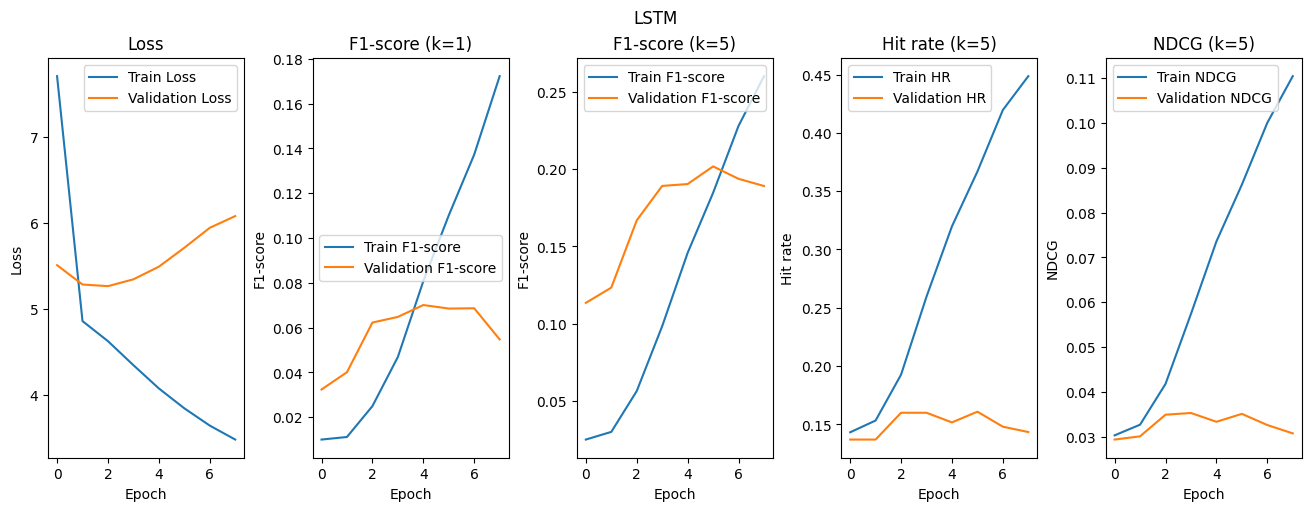

In [30]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_lstm.history['loss'], label='Train Loss')
ax1.plot(history_model_lstm.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_lstm.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_lstm.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_lstm.history['f1_score_at_k'], label='Train F1-score')
ax3.plot(history_model_lstm.history['val_f1_score_at_k'], label='Validation F1-score')
ax3.set_title('F1-score (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-score')
ax3.legend()

ax4.plot(history_model_lstm.history['hit_rate_at_k'], label='Train HR')
ax4.plot(history_model_lstm.history['val_hit_rate_at_k'], label='Validation HR')
ax4.set_title('Hit rate (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Hit rate')
ax4.legend()

ax5.plot(history_model_lstm.history['ndcg_at_k'], label='Train NDCG')
ax5.plot(history_model_lstm.history['val_ndcg_at_k'], label='Validation NDCG')
ax5.set_title('NDCG (k=5)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('NDCG')
ax5.legend()

plt.suptitle('LSTM')
plt.show()

In [31]:
model_lstm_test_loss, model_lstm_test_accuracy, model_lstm_test_f1_score_k_1, model_lstm_test_f1_score_k_5, model_lstm_test_hr, model_lstm_test_ndcg = model_lstm.evaluate(test_dataset)

print("Test loss:", round(model_lstm_test_loss, 4))
print("Test accuracy:", round(model_lstm_test_accuracy, 4))
print("Test F1@1:", round(model_lstm_test_f1_score_k_1, 4))
print("Test F1@5:", round(model_lstm_test_f1_score_k_5, 4))
print("Test HR@5:", round(model_lstm_test_hr, 4))
print("Test NDCG@5:", round(model_lstm_test_ndcg, 4))

parameters["model_lstm_test_loss"] = model_lstm_test_loss
parameters["model_lstm_test_accuracy"] = round(model_lstm_test_accuracy, 4)
parameters["model_lstm_test_f1_score_k_1"] = round(model_lstm_test_f1_score_k_1, 4)
parameters["model_lstm_test_f1_score_k_5"] = round(model_lstm_test_f1_score_k_5, 4)
parameters["model_lstm_test_hr"] = round(model_lstm_test_hr, 4)
parameters["model_lstm_test_ndcg"] = round(model_lstm_test_ndcg, 4)

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.0525 - f1_score: 0.0828 - f1_score_at_k: 0.2156 - hit_rate_at_k: 0.1672 - loss: 5.9173 - ndcg_at_k: 0.0374
Test loss: 6.3581
Test accuracy: 0.0507
Test F1@1: 0.0848
Test F1@5: 0.1978
Test HR@5: 0.1557
Test NDCG@5: 0.0356


In [32]:
parameters

{'user': 'users-15',
 'user_id': 'A8K5I4MF6QCGJ',
 'number_of_sequences_and_targets_before_removal': 10614,
 'number_of_sequences_and_targets_after_removal': 10123,
 'number_of_sequences_and_targets_after_dropping_duplicates_after_encoding': 10057,
 'num_unique_product_ids_in_targets': 270,
 'num_unique_product_ids_in_sequences': 7598,
 'number_of_sequences_and_targets_train': 7934,
 'number_of_sequences_and_targets_validation': 1057,
 'number_of_sequences_and_targets_test': 1066,
 'number_of_unique_products_in_targets_train': 236,
 'number_of_unique_products_in_targets_validation': 253,
 'number_of_unique_products_in_targets_test': 270,
 'model_lstm_test_loss': 6.358052730560303,
 'model_lstm_test_accuracy': 0.0507,
 'model_lstm_test_f1_score_k_1': 0.0848,
 'model_lstm_test_f1_score_k_5': 0.1978,
 'model_lstm_test_hr': 0.1557,
 'model_lstm_test_ndcg': 0.0356}

---------

## Bidirectional-LSTM

In [33]:
model_bi_lstm = Sequential()
model_bi_lstm.add(Embedding(input_dim=max_product_id, output_dim=50))
model_bi_lstm.add(Bidirectional(LSTM(32, activation='relu', return_sequences=True)))
model_bi_lstm.add(BatchNormalization())
model_bi_lstm.add(Dropout(0.2))
model_bi_lstm.add(Bidirectional(LSTM(32, activation='relu')))
model_bi_lstm.add(BatchNormalization())
model_bi_lstm.add(Dropout(0.2))
model_bi_lstm.add(Dense(16, activation='relu'))
model_bi_lstm.add(Dense(max_product_id, activation='softmax'))

model_bi_lstm.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [34]:
history_model_bi_lstm = model_bi_lstm.fit(
    train_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 26s 50ms/step - accuracy: 0.0342 - f1_score: 0.0058 - f1_score_at_k: 0.0246 - hit_rate_at_k: 0.1273 - loss: 9.5981 - ndcg_at_k: 0.0272 - val_accuracy: 0.0322 - val_f1_score: 0.0313 - val_f1_score_at_k: 0.1163 - val_hit_rate_at_k: 0.1406 - val_loss: 5.4727 - val_ndcg_at_k: 0.0288
Epoch 2/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.0385 - f1_score: 0.0155 - f1_score_at_k: 0.0361 - hit_rate_at_k: 0.1611 - loss: 4.8134 - ndcg_at_k: 0.0339 - val_accuracy: 0.0426 - val_f1_score: 0.0448 - val_f1_score_at_k: 0.1423 - val_hit_rate_at_k: 0.1535 - val_loss: 5.2786 - val_ndcg_at_k: 0.0330
Epoch 3/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.0561 - f1_score: 0.0299 - f1_score_at_k: 0.0566 - hit_rate_at_k: 0.1957 - loss: 4.5630 - ndcg_at_k: 0.0431 - val_accuracy: 0.0492 - val_f1_score: 0.0585 - val_f1_score_at_k: 0.1701 - val_hit_rate_at_k: 0.1664 - val_loss: 5.2825 - val_ndcg_at_k: 0.0364
Epoch 4/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 7

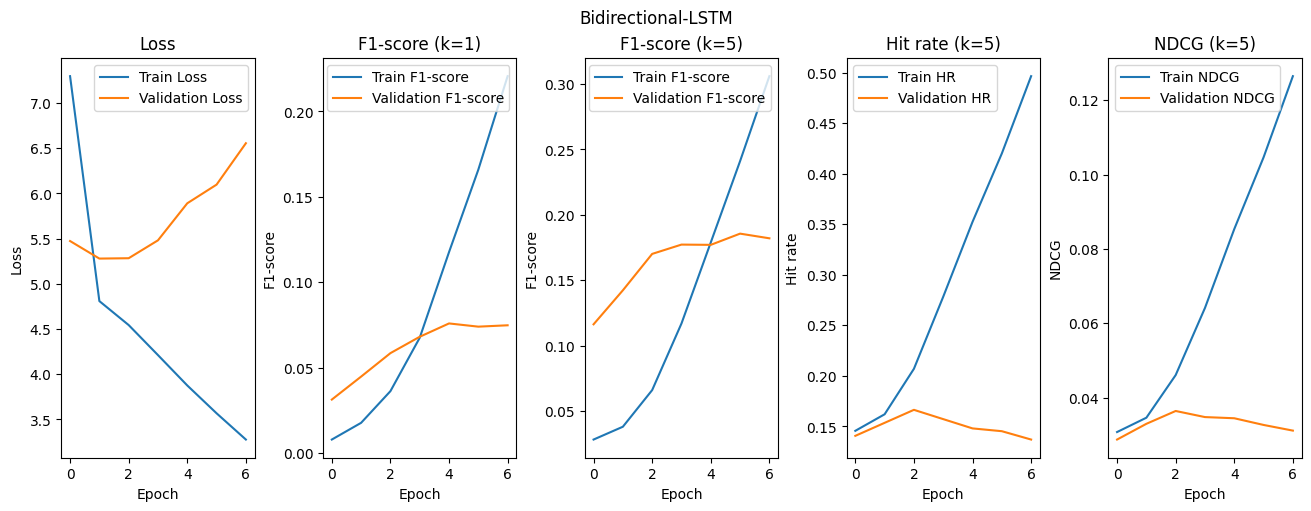

In [35]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_bi_lstm.history['loss'], label='Train Loss')
ax1.plot(history_model_bi_lstm.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_bi_lstm.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_bi_lstm.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_bi_lstm.history['f1_score_at_k'], label='Train F1-score')
ax3.plot(history_model_bi_lstm.history['val_f1_score_at_k'], label='Validation F1-score')
ax3.set_title('F1-score (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-score')
ax3.legend()

ax4.plot(history_model_bi_lstm.history['hit_rate_at_k'], label='Train HR')
ax4.plot(history_model_bi_lstm.history['val_hit_rate_at_k'], label='Validation HR')
ax4.set_title('Hit rate (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Hit rate')
ax4.legend()

ax5.plot(history_model_bi_lstm.history['ndcg_at_k'], label='Train NDCG')
ax5.plot(history_model_bi_lstm.history['val_ndcg_at_k'], label='Validation NDCG')
ax5.set_title('NDCG (k=5)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('NDCG')
ax5.legend()

plt.suptitle('Bidirectional-LSTM')
plt.show()

In [36]:
model_bi_lstm_test_loss, model_bi_lstm_test_accuracy, model_bi_lstm_test_f1_score_k_1, model_bi_lstm_test_f1_score_k_5, model_bi_lstm_test_hr, model_bi_lstm_test_ndcg = model_bi_lstm.evaluate(test_dataset)

print("Test loss:", round(model_bi_lstm_test_loss, 4))
print("Test accuracy:", round(model_bi_lstm_test_accuracy, 4))
print("Test F1@1:", round(model_bi_lstm_test_f1_score_k_1, 4))
print("Test F1@5:", round(model_bi_lstm_test_f1_score_k_5, 4))
print("Test HR@5:", round(model_bi_lstm_test_hr, 4))
print("Test NDCG@5:", round(model_bi_lstm_test_ndcg, 4))

parameters["model_bi_lstm_test_loss"] = model_bi_lstm_test_loss
parameters["model_bi_lstm_test_accuracy"] = round(model_bi_lstm_test_accuracy, 4)
parameters["model_bi_lstm_test_f1_score_k_1"] = round(model_bi_lstm_test_f1_score_k_1, 4)
parameters["model_bi_lstm_test_f1_score_k_5"] = round(model_bi_lstm_test_f1_score_k_5, 4)
parameters["model_bi_lstm_test_hr"] = round(model_bi_lstm_test_hr, 4)
parameters["model_bi_lstm_test_ndcg"] = round(model_bi_lstm_test_ndcg, 4)

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.0683 - f1_score: 0.1038 - f1_score_at_k: 0.2393 - hit_rate_at_k: 0.1842 - loss: 6.0736 - ndcg_at_k: 0.0426
Test loss: 6.7318
Test accuracy: 0.0582
Test F1@1: 0.0896
Test F1@5: 0.2193
Test HR@5: 0.1726
Test NDCG@5: 0.0398


In [37]:
parameters

{'user': 'users-15',
 'user_id': 'A8K5I4MF6QCGJ',
 'number_of_sequences_and_targets_before_removal': 10614,
 'number_of_sequences_and_targets_after_removal': 10123,
 'number_of_sequences_and_targets_after_dropping_duplicates_after_encoding': 10057,
 'num_unique_product_ids_in_targets': 270,
 'num_unique_product_ids_in_sequences': 7598,
 'number_of_sequences_and_targets_train': 7934,
 'number_of_sequences_and_targets_validation': 1057,
 'number_of_sequences_and_targets_test': 1066,
 'number_of_unique_products_in_targets_train': 236,
 'number_of_unique_products_in_targets_validation': 253,
 'number_of_unique_products_in_targets_test': 270,
 'model_lstm_test_loss': 6.358052730560303,
 'model_lstm_test_accuracy': 0.0507,
 'model_lstm_test_f1_score_k_1': 0.0848,
 'model_lstm_test_f1_score_k_5': 0.1978,
 'model_lstm_test_hr': 0.1557,
 'model_lstm_test_ndcg': 0.0356,
 'model_bi_lstm_test_loss': 6.731827735900879,
 'model_bi_lstm_test_accuracy': 0.0582,
 'model_bi_lstm_test_f1_score_k_1': 0.08

-------

# GRU

In [38]:
model_gru = Sequential()
model_gru.add(Embedding(input_dim=max_product_id, output_dim=50))
model_gru.add(GRU(32, activation='relu', return_sequences=True))
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.2))
model_gru.add(GRU(32, activation='relu'))
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.2))
model_gru.add(Dense(16, activation='relu'))
model_gru.add(Dense(max_product_id, activation='softmax'))

model_gru.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [39]:
history_model_gru = model_gru.fit(
    train_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.0331 - f1_score: 0.0088 - f1_score_at_k: 0.0230 - hit_rate_at_k: 0.1257 - loss: 9.8593 - ndcg_at_k: 0.0269 - val_accuracy: 0.0227 - val_f1_score: 0.0160 - val_f1_score_at_k: 0.1046 - val_hit_rate_at_k: 0.1369 - val_loss: 5.3719 - val_ndcg_at_k: 0.0271
Epoch 2/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.0379 - f1_score: 0.0083 - f1_score_at_k: 0.0262 - hit_rate_at_k: 0.1474 - loss: 4.8855 - ndcg_at_k: 0.0314 - val_accuracy: 0.0303 - val_f1_score: 0.0387 - val_f1_score_at_k: 0.1154 - val_hit_rate_at_k: 0.1342 - val_loss: 5.3177 - val_ndcg_at_k: 0.0275
Epoch 3/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.0402 - f1_score: 0.0106 - f1_score_at_k: 0.0317 - hit_rate_at_k: 0.1596 - loss: 4.7625 - ndcg_at_k: 0.0340 - val_accuracy: 0.0416 - val_f1_score: 0.0469 - val_f1_score_at_k: 0.1509 - val_hit_rate_at_k: 0.1489 - val_loss: 5.2901 - val_ndcg_at_k: 0.0320
Epoch 4/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 6

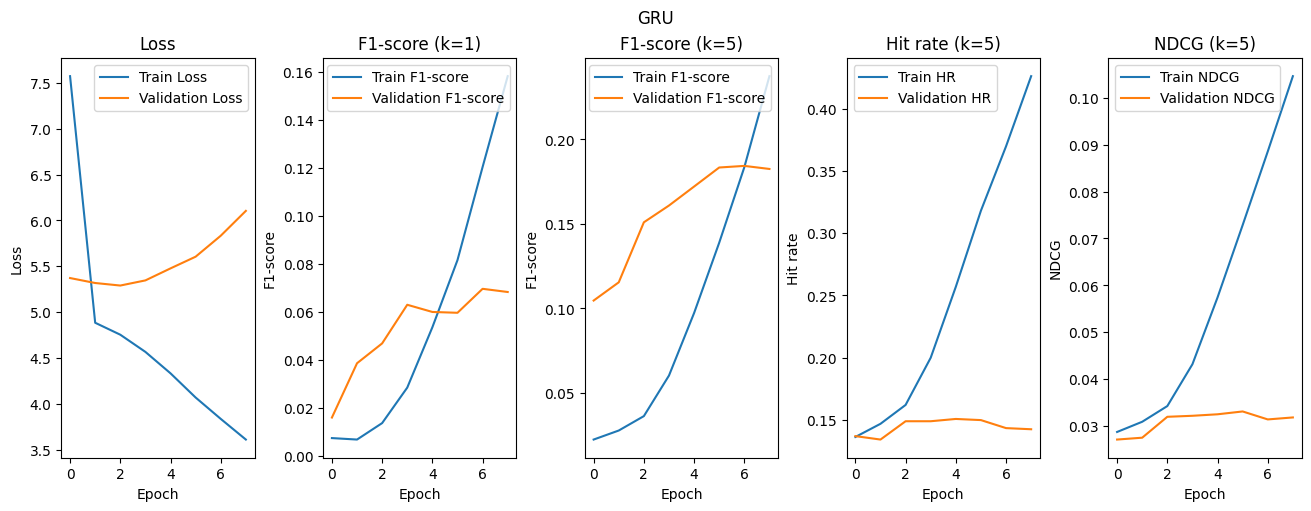

In [40]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_gru.history['loss'], label='Train Loss')
ax1.plot(history_model_gru.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_gru.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_gru.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_gru.history['f1_score_at_k'], label='Train F1-score')
ax3.plot(history_model_gru.history['val_f1_score_at_k'], label='Validation F1-score')
ax3.set_title('F1-score (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-score')
ax3.legend()

ax4.plot(history_model_gru.history['hit_rate_at_k'], label='Train HR')
ax4.plot(history_model_gru.history['val_hit_rate_at_k'], label='Validation HR')
ax4.set_title('Hit rate (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Hit rate')
ax4.legend()

ax5.plot(history_model_gru.history['ndcg_at_k'], label='Train NDCG')
ax5.plot(history_model_gru.history['val_ndcg_at_k'], label='Validation NDCG')
ax5.set_title('NDCG (k=5)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('NDCG')
ax5.legend()

plt.suptitle('GRU')
plt.show()

In [41]:
model_gru_test_loss, model_gru_test_accuracy, model_gru_test_f1_score_k_1, model_gru_test_f1_score_k_5, model_gru_test_hr, model_gru_test_ndcg = model_gru.evaluate(test_dataset)

print("Test loss:", round(model_gru_test_loss, 4))
print("Test accuracy:", round(model_gru_test_accuracy, 4))
print("Test F1@1:", round(model_gru_test_f1_score_k_1, 4))
print("Test F1@5:", round(model_gru_test_f1_score_k_5, 4))
print("Test HR@5:", round(model_gru_test_hr, 4))
print("Test NDCG@5:", round(model_gru_test_ndcg, 4))

parameters["model_gru_test_loss"] = model_gru_test_loss
parameters["model_gru_test_accuracy"] = round(model_gru_test_accuracy, 4)
parameters["model_gru_test_f1_score_k_1"] = round(model_gru_test_f1_score_k_1, 4)
parameters["model_gru_test_f1_score_k_5"] = round(model_gru_test_f1_score_k_5, 4)
parameters["model_gru_test_hr"] = round(model_gru_test_hr, 4)
parameters["model_gru_test_ndcg"] = round(model_gru_test_ndcg, 4)

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.0636 - f1_score: 0.0980 - f1_score_at_k: 0.2490 - hit_rate_at_k: 0.2007 - loss: 5.8559 - ndcg_at_k: 0.0448
Test loss: 6.3976
Test accuracy: 0.0507
Test F1@1: 0.0813
Test F1@5: 0.2052
Test HR@5: 0.1581
Test NDCG@5: 0.036


In [42]:
parameters

{'user': 'users-15',
 'user_id': 'A8K5I4MF6QCGJ',
 'number_of_sequences_and_targets_before_removal': 10614,
 'number_of_sequences_and_targets_after_removal': 10123,
 'number_of_sequences_and_targets_after_dropping_duplicates_after_encoding': 10057,
 'num_unique_product_ids_in_targets': 270,
 'num_unique_product_ids_in_sequences': 7598,
 'number_of_sequences_and_targets_train': 7934,
 'number_of_sequences_and_targets_validation': 1057,
 'number_of_sequences_and_targets_test': 1066,
 'number_of_unique_products_in_targets_train': 236,
 'number_of_unique_products_in_targets_validation': 253,
 'number_of_unique_products_in_targets_test': 270,
 'model_lstm_test_loss': 6.358052730560303,
 'model_lstm_test_accuracy': 0.0507,
 'model_lstm_test_f1_score_k_1': 0.0848,
 'model_lstm_test_f1_score_k_5': 0.1978,
 'model_lstm_test_hr': 0.1557,
 'model_lstm_test_ndcg': 0.0356,
 'model_bi_lstm_test_loss': 6.731827735900879,
 'model_bi_lstm_test_accuracy': 0.0582,
 'model_bi_lstm_test_f1_score_k_1': 0.08

-------

# Autoencoder

In [43]:
nn = [64, 32, 16, 32, 64]

model_autoencoder = Sequential()
model_autoencoder.add(Embedding(input_dim=max_product_id, output_dim=50))
model_autoencoder.add(Flatten())
model_autoencoder.add(Dense(units=nn[0], activation='relu'))
model_autoencoder.add(BatchNormalization())
model_autoencoder.add(Dropout(0.2))
for n in nn[1:]:
    model_autoencoder.add(Dense(units=n, activation='relu'))
    model_autoencoder.add(BatchNormalization())
    model_autoencoder.add(Dropout(0.2))
model_autoencoder.add(Dense(max_product_id, activation='softmax'))

model_autoencoder.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [44]:
history_model_autoencoder = model_autoencoder.fit(
    train_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 26s 51ms/step - accuracy: 0.0117 - f1_score: 0.0106 - f1_score_at_k: 0.0269 - hit_rate_at_k: 0.0428 - loss: 11.5121 - ndcg_at_k: 0.0090 - val_accuracy: 0.0237 - val_f1_score: 0.0146 - val_f1_score_at_k: 0.1016 - val_hit_rate_at_k: 0.1259 - val_loss: 6.1017 - val_ndcg_at_k: 0.0243
Epoch 2/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.0351 - f1_score: 0.0184 - f1_score_at_k: 0.0378 - hit_rate_at_k: 0.1378 - loss: 5.5504 - ndcg_at_k: 0.0293 - val_accuracy: 0.0331 - val_f1_score: 0.0350 - val_f1_score_at_k: 0.1228 - val_hit_rate_at_k: 0.1360 - val_loss: 5.1594 - val_ndcg_at_k: 0.0287
Epoch 3/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.0440 - f1_score: 0.0210 - f1_score_at_k: 0.0440 - hit_rate_at_k: 0.1640 - loss: 4.7657 - ndcg_at_k: 0.0353 - val_accuracy: 0.0464 - val_f1_score: 0.0608 - val_f1_score_at_k: 0.1275 - val_hit_rate_at_k: 0.1406 - val_loss: 5.1566 - val_ndcg_at_k: 0.0312
Epoch 4/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 

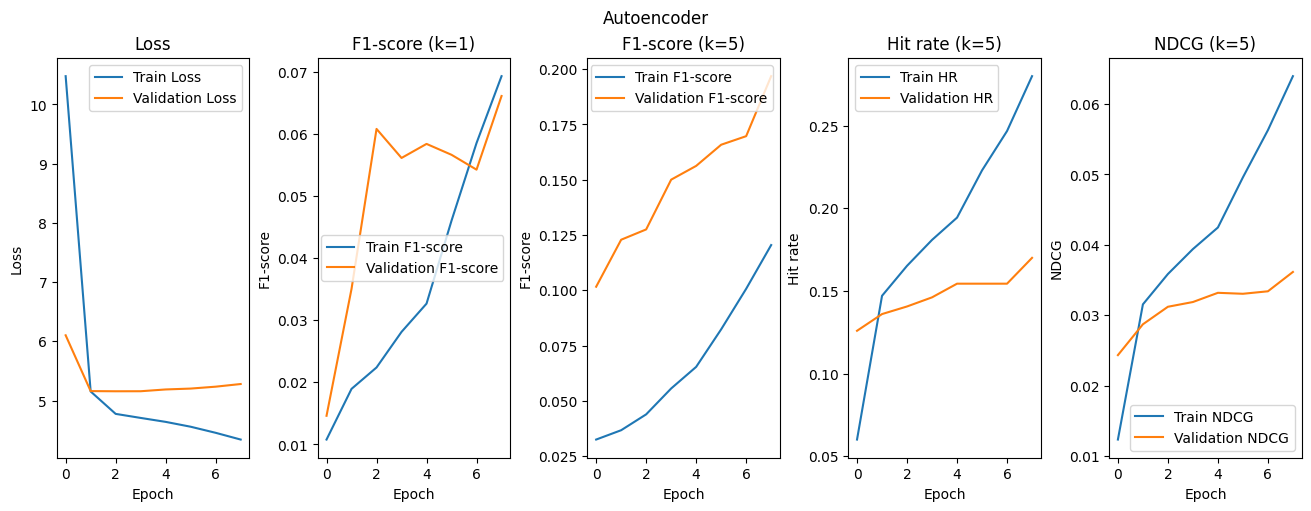

In [45]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_autoencoder.history['loss'], label='Train Loss')
ax1.plot(history_model_autoencoder.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_autoencoder.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_autoencoder.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_autoencoder.history['f1_score_at_k'], label='Train F1-score')
ax3.plot(history_model_autoencoder.history['val_f1_score_at_k'], label='Validation F1-score')
ax3.set_title('F1-score (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-score')
ax3.legend()

ax4.plot(history_model_autoencoder.history['hit_rate_at_k'], label='Train HR')
ax4.plot(history_model_autoencoder.history['val_hit_rate_at_k'], label='Validation HR')
ax4.set_title('Hit rate (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Hit rate')
ax4.legend()

ax5.plot(history_model_autoencoder.history['ndcg_at_k'], label='Train NDCG')
ax5.plot(history_model_autoencoder.history['val_ndcg_at_k'], label='Validation NDCG')
ax5.set_title('NDCG (k=5)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('NDCG')
ax5.legend()

plt.suptitle('Autoencoder')
plt.show()

In [46]:
model_autoencoder_test_loss, model_autoencoder_test_accuracy, model_autoencoder_test_f1_score_k_1, model_autoencoder_test_f1_score_k_5, model_autoencoder_test_hr, model_autoencoder_test_ndcg = model_autoencoder.evaluate(test_dataset)

print("Test loss:", round(model_autoencoder_test_loss, 4))
print("Test accuracy:", round(model_autoencoder_test_accuracy, 4))
print("Test F1@1:", round(model_autoencoder_test_f1_score_k_1, 4))
print("Test F1@5:", round(model_autoencoder_test_f1_score_k_5, 4))
print("Test HR@5:", round(model_autoencoder_test_hr, 4))
print("Test NDCG@5:", round(model_autoencoder_test_ndcg, 4))

parameters["model_autoencoder_test_loss"] = model_autoencoder_test_loss
parameters["model_autoencoder_test_accuracy"] = round(model_autoencoder_test_accuracy, 4)
parameters["model_autoencoder_test_f1_score_k_1"] = round(model_autoencoder_test_f1_score_k_1, 4)
parameters["model_autoencoder_test_f1_score_k_5"] = round(model_autoencoder_test_f1_score_k_5, 4)
parameters["model_autoencoder_test_hr"] = round(model_autoencoder_test_hr, 4)
parameters["model_autoencoder_test_ndcg"] = round(model_autoencoder_test_ndcg, 4)

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.0621 - f1_score: 0.0849 - f1_score_at_k: 0.2414 - hit_rate_at_k: 0.2090 - loss: 5.0626 - ndcg_at_k: 0.0467
Test loss: 5.4477
Test accuracy: 0.0488
Test F1@1: 0.0667
Test F1@5: 0.1844
Test HR@5: 0.1642
Test NDCG@5: 0.0375


In [47]:
parameters

{'user': 'users-15',
 'user_id': 'A8K5I4MF6QCGJ',
 'number_of_sequences_and_targets_before_removal': 10614,
 'number_of_sequences_and_targets_after_removal': 10123,
 'number_of_sequences_and_targets_after_dropping_duplicates_after_encoding': 10057,
 'num_unique_product_ids_in_targets': 270,
 'num_unique_product_ids_in_sequences': 7598,
 'number_of_sequences_and_targets_train': 7934,
 'number_of_sequences_and_targets_validation': 1057,
 'number_of_sequences_and_targets_test': 1066,
 'number_of_unique_products_in_targets_train': 236,
 'number_of_unique_products_in_targets_validation': 253,
 'number_of_unique_products_in_targets_test': 270,
 'model_lstm_test_loss': 6.358052730560303,
 'model_lstm_test_accuracy': 0.0507,
 'model_lstm_test_f1_score_k_1': 0.0848,
 'model_lstm_test_f1_score_k_5': 0.1978,
 'model_lstm_test_hr': 0.1557,
 'model_lstm_test_ndcg': 0.0356,
 'model_bi_lstm_test_loss': 6.731827735900879,
 'model_bi_lstm_test_accuracy': 0.0582,
 'model_bi_lstm_test_f1_score_k_1': 0.08

-----

#### Predicting target for the last sequence of the specific user

In [48]:
predicted_user = {
    'userID': last_user_sequence[0],
    'sequence': [encoding[last_user_sequence[2]], encoding[last_user_sequence[3]]],
    'target': encoding[last_user_sequence[1]]
}

predicted_user

{'userID': 'A8K5I4MF6QCGJ', 'sequence': [22705, 78310], 'target': 52169}

In [49]:
input_data = np.array([predicted_user['sequence']])
predictions = model_lstm.predict(input_data)

k_values = [5, 10, 20, 50, 100, 200, 300, 400, 500]

for k in k_values:
    hit_rate = hit_rate_at_k(np.array([predicted_user['target']]), predictions, k=k).numpy()
    print(f"HT@{k}: {hit_rate}")
    
    ndcg = ndcg_at_k(np.array([predicted_user['target']]), predictions, k=k).numpy()
    print(f"NDCG@{k}: {ndcg}")
    
    print("-------------")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step
HT@5: 0.0
NDCG@5: 0.0
-------------
HT@10: 0.0
NDCG@10: 0.0
-------------
HT@20: 0.0
NDCG@20: 0.0
-------------
HT@50: 0.0
NDCG@50: 0.0
-------------
HT@100: 0.0
NDCG@100: 0.0
-------------
HT@200: 1.0
NDCG@200: 0.003841860219836235
-------------
HT@300: 1.0
NDCG@300: 0.0028233295306563377
-------------
HT@400: 1.0
NDCG@400: 0.002259103348478675
-------------
HT@500: 1.0
NDCG@500: 0.0018958646105602384
-------------
